# LFM2-VL の Supervised Fine-Tuning (SFT + LoRA)

# パッケージインストール

In [15]:
!pip install -qqq transformers==4.55.0 datasets trl --progress-bar off

In [16]:
import torch
import transformers
import trl
import os
os.environ["WANDB_DISABLED"] = "true"

print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"TRL version: {trl.__version__}")

PyTorch version: 2.8.0+cu126
Transformers version: 4.55.0
TRL version: 0.22.1


# モデル読み込み


In [17]:
import torch
from transformers import AutoModelForImageTextToText, AutoProcessor

model_id = "LiquidAI/LFM2-VL-450M" # or LiquidAI/LFM2-VL-1.6B

print("Loading processor...")
processor_source = model_id
processor = AutoProcessor.from_pretrained(
    processor_source,
    trust_remote_code=True,
    max_image_tokens=256,
)

print("Loading model...")
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype="bfloat16",
    trust_remote_code=True,
    device_map="auto",
)

print(f"Vocab size: {len(processor.tokenizer)}")
print(f"Image processed in up to {processor.max_tiles} patches of size {processor.tile_size}")
print(f"Parameters: {model.num_parameters():,}")
print(f"Model size: ~{model.num_parameters() * 2 / 1e9:.1f} GB (bfloat16)")

Loading processor...
Loading model...
Vocab size: 64400
Image processed in up to 10 patches of size 512
Parameters: 450,822,656
Model size: ~0.9 GB (bfloat16)


# データセット読み込み
医療QA用の小規模データセット [simwit/omni-med-vqa-mini](https://huggingface.co/datasets/simwit/omni-med-vqa-mini) を利用

In [18]:
from datasets import load_dataset

raw_ds = load_dataset("simwit/omni-med-vqa-mini")
full_dataset = raw_ds["test"]
split = full_dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = split["train"]
eval_dataset = split["test"]

print(f"Train samples: {len(train_dataset)}")
print(f"Eval samples: {len(eval_dataset)}")

Train samples: 1600
Eval samples: 400


データセットを TRL と互換性のある形式に変換

In [19]:
system_message = (
    "You are a medical Vision Language Model specialized in analyzing medical images and providing clinical insights. "
    "Provide concise, clinically relevant answers based on the image and question."
)

def format_medical_sample(sample):
    return [
        {"role": "system", "content": [{"type": "text", "text": system_message}]},
        {
            "role": "user",
            "content": [
                {"type": "image", "image": sample["image"]},
                {"type": "text", "text": sample["question"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["gt_answer"]}]},
    ]

train_dataset = [format_medical_sample(s) for s in train_dataset]
eval_dataset = [format_medical_sample(s) for s in eval_dataset]

print(f"Train samples: {len(train_dataset)}")
print(f"Eval samples: {len(eval_dataset)}")

Train samples: 1600
Eval samples: 400


# Collate 関数準備
チャットテキストと対応するRGB画像をバッチ化し、モデルに入力可能なテンソルへ変換

In [20]:
def create_collate_fn(processor):
    """Create a collate function that prepares batch inputs for the processor."""
    def collate_fn(sample):
        batch = processor.apply_chat_template(sample, tokenize=True, return_dict=True, return_tensors="pt")
        labels = batch["input_ids"].clone()
        labels[labels == processor.tokenizer.pad_token_id] = -100
        batch["labels"] = labels
        return batch
    return collate_fn

collate_fn = create_collate_fn(processor)

# PEFTでモデルをラップ

微調整する対象モジュールを指定し、それ以外のモデルの重みは固定したままにする ※r（ランク） の値は自由に変更可

- Higher → フル微調整に近い精度を得られる
- Lower → より少ない計算資源で済む

もし高性能なGPUを持っていてフル微調整を行いたい場合、この部分は省略して良い

In [21]:
from peft import LoraConfig, get_peft_model

target_modules = [
    "q_proj", "v_proj", "fc1", "fc2", "linear",
    "gate_proj", "up_proj", "down_proj",
]

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=8,
    bias="none",
    target_modules=target_modules,
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 1,204,224 || all params: 452,026,880 || trainable%: 0.2664


# 学習実施

In [22]:
from trl import SFTConfig, SFTTrainer

sft_config = SFTConfig(
    output_dir="lfm2-vl-med",
    num_train_epochs=3,
    # num_train_epochs=10,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    learning_rate=5e-4,
    warmup_ratio=0.1,
    weight_decay=0.01,
    logging_steps=10,
    optim="adamw_torch_8bit",
    gradient_checkpointing=True,
    max_length=512,
    dataset_kwargs={"skip_prepare_dataset": True},
    report_to=None
)

print("Creating SFT trainer...")
sft_trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=collate_fn,
    processing_class=processor.tokenizer,
)

print("\nStarting SFT training...")
sft_trainer.train()

print("SFT training completed!")

sft_trainer.save_model()
print(f"Saving to: {sft_config.output_dir}")

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Creating SFT trainer...

Starting SFT training...


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
10,13.901500
20,13.219800
30,11.128600
40,8.856000
50,7.280400
60,6.618000
70,6.073300
80,5.645400
90,5.397000
100,5.207800


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


SFT training completed!
Saving to: lfm2-vl-med


# マージ済みモデルの保存

In [23]:
if hasattr(model, 'peft_config'):
    print("Merging LoRA weights...")
    model = model.merge_and_unload()
model.save_pretrained("./lfm2-vl-med")
processor.save_pretrained("./lfm2-vl-med")
print("Model saved to: ./lfm2-vl-med")

Merging LoRA weights...
Model saved to: ./lfm2-vl-med


In [24]:
from transformers import AutoProcessor, AutoModelForImageTextToText

model_id = "./lfm2-vl-med"

model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype="bfloat16",
    trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [25]:
from pprint import pprint

pprint(eval_dataset[0])

[{'content': [{'text': 'You are a medical Vision Language Model specialized in '
                       'analyzing medical images and providing clinical '
                       'insights. Provide concise, clinically relevant answers '
                       'based on the image and question.',
               'type': 'text'}],
  'role': 'system'},
 {'content': [{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1088x576 at 0x7F702A3C8110>,
               'type': 'image'},
              {'text': 'What medical condition does the image portray?',
               'type': 'text'}],
  'role': 'user'},
 {'content': [{'text': 'Pneumonia', 'type': 'text'}], 'role': 'assistant'}]


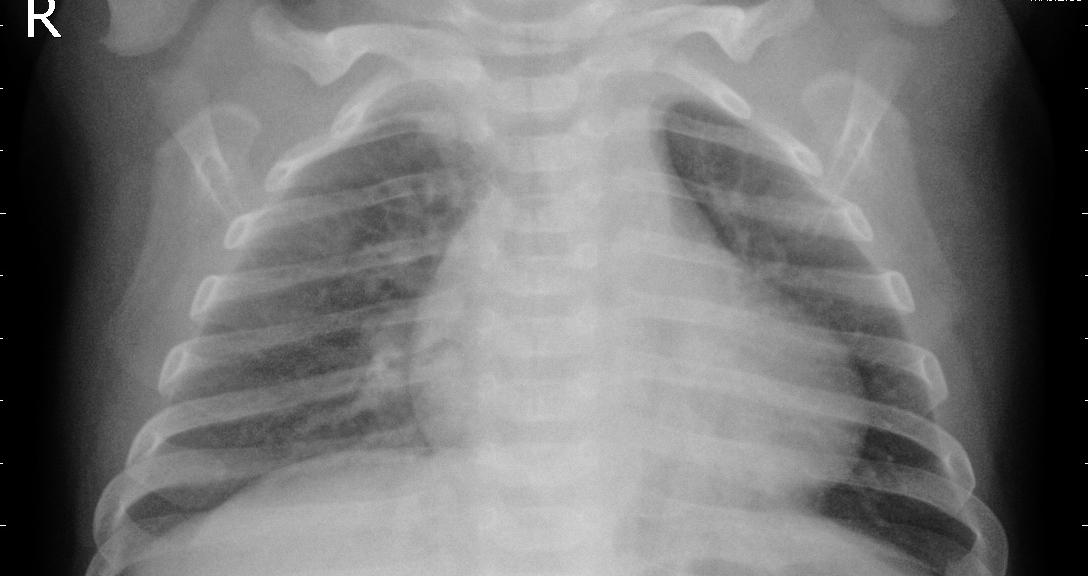

In [26]:
eval_dataset[0][1]["content"][0]["image"]

In [27]:
%%time

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": eval_dataset[0][1]["content"][0]["image"]
            },
            {
                "type": "text",
                "text": "What medical condition does the image portray"
            }
        ],
    }
]

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True,
    tokenize=True,
    min_image_tokens=64,     # 推奨パラメータ
    max_image_tokens=256,    # 推奨パラメータ
    do_image_splitting=True  # 推奨パラメータ
).to(model.device)

outputs = model.generate(
    **inputs,
    max_new_tokens=1024,
    do_sample=True,          # 推奨パラメータ
    temperature=0.1,         # 推奨パラメータ
    min_p=0.15,              # 推奨パラメータ
    repetition_penalty=1.05  # 推奨パラメータ
)
output_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]

CPU times: user 891 ms, sys: 8.96 ms, total: 900 ms
Wall time: 899 ms


In [28]:
print(output_text)

user
What medical condition does the image portray
assistant
The image portrays a medical condition known as "chronic venous thrombosis"
